Blatt 4
---

Übungstermin: 17. 05. 2017

In [1]:
from helpers import *
from numpy.random import normal

## Task 4.1 Cramer-Rao Schranke am Boccia-Beispiel:
<font color='#0d2b5b'>

Betrachten Sie das Boccia-Datenmodell aus dem Vorlesungsskript mit $y_i = wx^2 + \nu_i$ mit konstanter
Anfangsgeschwindigkeit $x = 0.5$ und dem Schätzer

$$\hat\omega= \frac 1N \sum_{i=1}^N \frac{y_i}{x^2}$$

Dabei sei $\nu_i \sim \mathcal{N} (0, \sigma^2)$ normalverteiltes Rauschen mit Varianz $\sigma^2 = 0.1$.  

</font>

In [3]:
from helpers import *
import seaborn as sns
%matplotlib inline

In [4]:
class BocciaDistribution:
    def __init__(self, sigma=0.1, x_0=0.5, w=1):
        self.sigma = sigma
        self.x_0 = x_0
        self.w = w
        self.mu = self.w * self.x_0**2

    def get_samples(self, n):
        noise = np.random.normal(0, self.sigma, n)
        ys = noise + self.mu
        return ys

In [7]:
def sample_mean(ys):
    mean = np.sum(ys) / len(ys)
    if len(ys) == 0:
        print("len 0")
    return mean

def sample_variance(ys):
    return np.sum((ys - sample_mean(ys))**2) / len(ys)


def plot_samples(samples, distribution, label="Boccia Distribution"):
    fig, ax = plt.subplots()
    sns.distplot(samples, hist=False, rug=True, ax=ax, label=label)
    draw_arrow(distribution.mu, 0.8, "true mean", ax, color='r')
    draw_arrow(sample_mean(samples), 1.1, "sample mean", ax, color='b')

def draw_arrow(x_pos, size, label, ax, **kwargs):
    plt.arrow(x_pos, size + 0.5, 0, -size, axes=ax, width=0.005, head_length=0.3, **kwargs)
    plt.text(x_pos, size + 0.6, label, axes=ax, horizontalalignment='center', **kwargs)

/usr/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


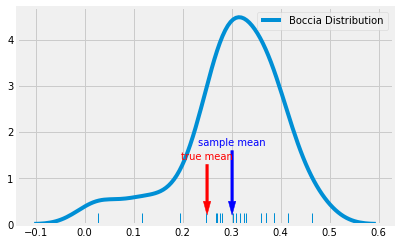

In [12]:
distribution = BocciaDistribution()
samples = distribution.get_samples(20)
plot_samples(samples, distribution)

<font color='#0d2b5b'>

Zeige experimentell über je $100$ Wiederholungen, dass für $N \in \{ 1, 2, 3, 5, 10, 100, 1000\}$
die Varianz der Schätzung, d.h. $Var(\hat\omega)$
gegen die Cramer-Rao Schranke konvergiert.
Plotte dazu $Var(\hat\omega)$ und 
$\frac{\sigma^2}{Nx^2}$
in Abhängigkeit von $N$.  

</font>

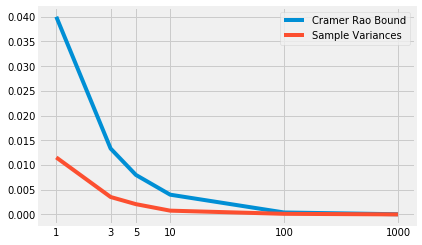

In [11]:
n_reps = 100
distribution = BocciaDistribution()
ns = np.array([1, 3, 5, 10, 100, 1000])
cramer_rao_bounds = distribution.sigma**2 / (ns * distribution.x_0**2)
sample_variances = [sample_variance(np.array(
    [sample_mean(distribution.get_samples(n)) for _ in range(n_reps)]
))for n in ns]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(ns, cramer_rao_bounds, label="Cramer Rao Bound")
ax.plot(ns, sample_variances, label="Sample Variances")
plt.xticks(ns, [str(n) for n in ns], axes=ax)
ax.legend();

<font color='#1d478c'>

Wie verändern sich die Schranke und die Schätzungen bei Variation von $\sigma^2$.  

</font>

## Task 4.2 Regularisierte Polynom-Regression:
<font color='#1d478c'>


Berechnen Sie die Regressionsformel für die quadratische Fehlerfunktion

$$
E = \frac12 \sum_{i=1}^N \left( y(x_i) - \hat y(x_i)\right)^2
+\lambda \frac12 \sum_{m=0}^M \hat\omega_m^2 \left(e^m-1\right)
$$
mit speziellem Regularisierungsterm gewichtet mit Parameter $\lambda$ für einen Polynomapproximator


$$
\hat y(x) = \sum_{m_0}^M \hat\omega_m^m
$$
.  

</font>

![Notizen](regularized_least_squares.jpeg)

<font color='#1d478c'>

Welche Idee steckt hinter diesem speziellem Regularisierungsansatz und wie wirkt sich die Regularisierung
auf die Lösungen der Regressiohttp://localhost:8888/files/regularized_least_squares.jpeg?1557787395007n aus?

</font>

Gewichte der höheren Polynomgerade sind 'teurer', sodass im Zweifel für ein fit geringerer Ordnung entschieden wird.

## Task 4.3 Bias-Varianz Dilemma am Beispiel der Polynom-Regression:
<font color='#1d478c'>

Untersuchen Sie den Einfluss der oben eingeführten Regularisierung auf die Schätzgenauigkeit.  
Als Datenmodell sei das Polynom $y(x, w) + \nu$ gegeben mit wahren Parametern  
$w_0 = 0.8$, $w_1 = 2.4$, $w_2 = −1.55$, $w_3 = −0.15$, $w_4 = 0.1$ und $\nu \sim\mathcal{n} (0, \omega^2 )$
mit $\omega^2 = 2$.  

</font>

<font color='#1d478c'>

Schätzen Sie wiederholt Modellparameter $\hat\omega$ für Polynome 8-ten Grades mittels der regularisierten
Regression aus Aufgabe 3.2. Erstellen Sie dazu $100$ Datensätze bestehend aus je $20$ Datenpunkten
$(x_i , y(x_i ) + \nu_i)$ mit uniform verteilten $x_i \in [−5, 5]$ und wiederholen Sie die Schätzung der Parameter
für jeden Datensatz und Regularisierungen $\lambda \in {0, 10−5 , 10−4 , . . . , 105}$.  

</font>

<font color='#1d478c'>

Welchen Einfluss hat $\lambda$ auf die Aufteilung des Schätzfehlers $h||w − \hat\omega||^2_i$
in Bias- und Varianz-Anteile?
Plotten Sie dazu den Bias des Schätzers, d.h. $||h\hat\omega_i − w||$^2 ,
sowie dessen Varianz $h||\hat\omega − h\hat\omega_i||$^2 i in Abhängigkeit von $\lambda$.  

</font>